In [18]:
import pandas as pd
import numpy as np
import pandasql as psql
import time
import math
import os
import role_classification_functions as rcf
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
pd.options.display.max_columns = None
beg=time.perf_counter()

#fname=os.getcwd()+'\\database'+'\\SouporSecret_4_23.csv'
fname=os.getcwd()+'\\Souporsecret_4_24_max.csv'

df_soup=pd.read_csv(fname)


df_soup1=df_soup[df_soup['queue'].isin(['5v5 Draft Pick games','5v5 Ranked Flex games','5v5 Ranked Solo games','5v5 Blind Pick games','Clash games'])]
df_soup2=rcf.new_lane_classification(df_soup1,cleaning=True)
print("scored error_pre: ", rcf.score_error(df_soup2))
df=df_soup2[df_soup2['roleErrorFlag'] == False].copy()
print("scored error: ", rcf.score_error(df))
print(len(df), "rows")
print(len(df['gameId'].drop_duplicates()), "games")
print(len(df_soup1['gameId'].drop_duplicates()), "possible games")
end=time.perf_counter()
runtime=end-beg
runtime_mins=int(runtime/60)
runtime_secs=int(runtime%60)
print(runtime_mins, " minutes and ", runtime_secs, "seconds.")
#error score with distance classification
#scored error_pre:  256
#scored error:  0
#491110 rows
#1583 games
#8ish mins?


#error score with new positional classification
# scored error_pre:  214
# scored error:  0
# 492440 rows
# 1585 games
# 7  minutes and  0 seconds.

#ignore positions classified as none. finalRole won't be = "None"
#Calvin:
# scored error_pre:  91
# scored error:  0
# 505760 rows
# 1631 games
# 1674 possible games
# 8  minutes and  46 seconds.

#Kevin:
# scored error:  0
# 197460 rows
# 614 games
# 632 possible games
# 3  minutes and  26 seconds.

#Mike:
# scored error_pre:  30
# scored error:  0
# 140890 rows
# 441 games
# 455 possible games
# 2  minutes and  3 seconds.


df.head(3)  

gameID:  3830577895
ADC LEN:  3
b:        minionsKilled  summonerName
9157              0   AerialBlast
9055             16  SouporSecret
9259             17        Reegal
gameID:  3804254703
ADC LEN:  3
b:         minionsKilled summonerName
19122              0        ACTMC
19094             12    Cleanup99
19010             21     iCurl20z
gameID:  3510340105
supp LEN:  3
b:         minionsKilled  summonerName
74682             19   AerialBlast
74580              2  SouporSecret
74835              0        Jemags
gameID:  3481050582
ADC LEN:  3
b:         minionsKilled  summonerName
85480              8   SpicedCider
85255             15        Viizay
85570             21  SouporSecret
gameID:  3480417266
ADC LEN:  3
b:         minionsKilled      summonerName
86329              2  ShadowSlayer2002
86197             15         haonriven
86241             19   Awesomest Sauce
gameID:  3451748144
ADC LEN:  3
b:         minionsKilled      summonerName
96177              0  SuperUnicornKi

,minute,participantId,totalGold,level,xp,minionsKilled,jungleMinionsKilled,gameId,gameDate,queue,teamId,win,championName,role,lane,summonerName,posX,posY,spell0,spell1,item0,item1,item2,item3,item4,item5,posLane,jungleFlag,supportFlag,finalRole,roleErrorFlag
0,0,5,500,1,0,0,0,3860182640,2021-04-09 14:58:17.491,5v5 Ranked Flex games,Blue,1,Akali,DUO,MIDDLE,IrishGuy,335,269,Ignite,Flash,Doran's Shield,Refillable Potion,Night Harvester,Mercury's Treads,Seeker's Armguard,False,MIDDLE,False,False,MIDDLE,False
1,1,5,500,1,0,0,0,3860182640,2021-04-09 14:58:17.491,5v5 Ranked Flex games,Blue,1,Akali,DUO,MIDDLE,IrishGuy,11345,6584,Ignite,Flash,Doran's Shield,Refillable Potion,Night Harvester,Mercury's Treads,Seeker's Armguard,False,MIDDLE,False,False,MIDDLE,False
2,2,5,612,1,270,5,0,3860182640,2021-04-09 14:58:17.491,5v5 Ranked Flex games,Blue,1,Akali,DUO,MIDDLE,IrishGuy,7347,7809,Ignite,Flash,Doran's Shield,Refillable Potion,Night Harvester,Mercury's Treads,Seeker's Armguard,False,MIDDLE,False,False,MIDDLE,False


In [19]:
''' @Params
    df = name of dataframe
    name = summoner name to mark
    Returns dataframe with column homeTeam, which is True if the team contains the entered summoner name. name is not case sensitive
'''
def mark_summoner(df, name):
    name_lower = name.lower()
    df['summonerName']=df['summonerName'].str.lower()
    #drop homeTeam if already is one
    df.drop(['homeTeam'], axis=1, errors='ignore', inplace=True)
    df_1 = df[['gameId','summonerName','teamId']].copy().drop_duplicates()
    df_2=df_1[df_1['summonerName']==name_lower].copy()
    #Create column of True for allrows with summoner, then go back and fill blanks with False
    df_2['homeTeam'] = [True for i in range(len(df_2))]
    df_3=df.merge(df_2[['gameId','teamId','homeTeam']],how='left',on = ['gameId','teamId'])
    df_3.fillna(False,inplace=True)
    return df_3

''' @Params
    df = name of dataframe
    own_name = summoner name of self
    teammate_name = summoner name of teammate 
    own_pos = OPTIONAL - select only games where self plays a certain role
    teaammate_post = OPTIONAL - select only games where teammate plays a certain role 
    Returns dataframe with only games where both summoners are in the game, and role criteria is met
'''
def mark_teammate(df, own_name, teammate_name, own_pos="", teammate_pos=""):

#own_name, teammate_name, own_pos, teammate_pos = "aerialblast","souporsecret","BOT_CARRY","SUPPORT"
    own_name, teammate_name = own_name.lower(), teammate_name.lower()

    df=mark_summoner(df, own_name)
    df_1 = df[['gameId','summonerName','homeTeam','finalRole']]
    df_2 = df_1[df_1['homeTeam']==True].copy().drop_duplicates()
    #create df of 1 column, gameIds, where we match a certain teammate's summoner name & Role
    if teammate_pos == "":
        print('yo')
        df_teammate=df_2[df_2['summonerName']==teammate_name].copy()
    else:
        df_teammate=df_2[(df_2['summonerName']==teammate_name) & (df_2['finalRole']==teammate_pos)][['gameId']]

    #create df of 1 column, gameIds, where we match our own summoner name & Role
    if own_pos!="":
        df_2=df_2[(df_2['summonerName']==own_name) & (df_2['finalRole']==own_pos)][['gameId']]
    #print(type(df),type(df_teammate))
    gameIds=df_teammate.merge(df_2,how='inner',on = ['gameId'])
    return df[df['gameId'].isin(gameIds['gameId'])].copy()



In [20]:
''' @Params
    df = name of dataframe
    name = summoner name **NOT USED YET
    minutes = time  to see gold diff
    ROLE = position: BOT_CARRY, SUPPORT, MIDDLE, JUNGLE, TOP
'''
def gold_diff_x(df, name, minutes=[10], role="BOT_CARRY"):
    
    df_1=mark_summoner(df,name)
    #print(len(df_1))
 
    df_out = pd.DataFrame()
    for minute, i in zip(minutes,range(len(minutes))):
        df_2=df_1[df_1['minute']==minute]
        prep=df_2[['gameId','minute','homeTeam','summonerName','championName','win','totalGold','minionsKilled','jungleMinionsKilled','finalRole']].copy()
        
        home=prep[(prep['summonerName']==name.lower()) & (prep['homeTeam']==True) & (prep['finalRole']==role)].copy()
        away=prep[(prep['homeTeam']==False) & (prep['finalRole']==role) ].copy()
        

        df_versus=home.merge(away, on = ["gameId","minute"])
        #print(df_versus)
        gd_col='goldDiff'+str(minute)
        csd_col='csDiff'+str(minute)
        df_versus[gd_col]=df_versus['totalGold_x'] - df_versus['totalGold_y'] 
        df_versus[csd_col]=df_versus['minionsKilled_x'] + df_versus['jungleMinionsKilled_x'] - df_versus['minionsKilled_y'] - df_versus['jungleMinionsKilled_y'] 
        df_stats=df_versus[['gameId', 'championName_x','championName_y','win_x', gd_col, csd_col]]
        #print(df_stats)
        #combine stats for each minute
        if i==0:
            df_out=df_out.append(df_stats)
        else:
            #only print winrate once.
            df_out=df_out.merge(df_stats.drop(['win_x'],axis=1), on=['gameId', 'championName_x','championName_y'],how="left")

    return df_out

    #Returns summary of output of gold_diff function
def summarize_stats(df,champ_team="home"):
    if champ_team == "home" or champ_team == "Home":
        champ_name_type='championName_x'
    else:
        champ_name_type='championName_y'

    stats_list=[]
    for champ in df[champ_name_type].drop_duplicates():
        champ_row = {}
        champ_df=df[df[champ_name_type]==champ]
        champ_row['champion']=champ
        champ_row['games']=len(champ_df)
        #calculate mean for the statistical columns. this will be the GD and CSD for each minute, and the winrate
        for column in list(champ_df.columns[3:]):
            champ_row[column]=champ_df[column].mean(skipna=True)
        stats_list.append(champ_row)
    to_return=pd.DataFrame(stats_list).round(2).sort_values(by="games",ascending=False)
    to_return.rename(columns={"win_x": "winrate"},inplace=True)
    #this turns it into a styler object?
    # format_dict={'winrate': "{:.0%}"}
    # for colname in to_return.columns[3:]:
    #    format_dict[colname]="{:.0f}"
    
    return to_return#.style.format(format_dict)


In [21]:
#display(summarize_stats(gold_diff_x(df,"SouporSecret",minutes=[10, 15],role="SUPPORT")))
#display(summarize_stats(gold_diff_x(df,"SouporSecret",minutes=[10, 15],role="SUPPORT"),champ_team="Away"))

x=gold_diff_x(df,"souporsecret",minutes=[10, 15],role="SUPPORT")
#display(x)
y=summarize_stats(x,champ_team="home")
#y
format_dict={'winrate': "{:.0%}",
                'goldDiff10': "{:.0f}",
                'csDiff10': "{:.0f}",
                'goldDiff15': "{:.0f}",
                'csDiff15': "{:.0f}"}
pd.options.display.max_rows = 10
y.style.format(format_dict)

,champion,games,winrate,goldDiff10,csDiff10,goldDiff15,csDiff15
5,Seraphine,35,74%,309,-5,588,-6
3,Leona,34,53%,-58,3,-102,4
0,Thresh,29,41%,93,6,135,7
8,Bard,11,36%,19,-5,-159,-6
2,Zyra,10,50%,368,-7,665,-10
6,Karma,9,33%,-55,-3,6,-4
15,Lux,4,75%,197,8,-256,10
14,Nami,4,0%,-637,1,-1036,2
1,Alistar,3,67%,-74,3,-210,7
10,Veigar,3,0%,-129,5,-564,9


In [22]:
df_mk=mark_teammate(df,"souporsecret","aerialblast",own_pos="SUPPORT",teammate_pos="BOT_CARRY")
mike_kev=gold_diff_x(df_mk,"souporsecret",minutes=[10, 15],role="SUPPORT")
mike_kev_2=summarize_stats(mike_kev,champ_team="home")
#z=mike_calvin_2.winrate*mike_calvin_2.games
#sum(z)

format_dict={'winrate': "{:.0%}",
                'goldDiff10': "{:.0f}",
                'csDiff10': "{:.0f}",
                'goldDiff15': "{:.0f}",
                'csDiff15': "{:.0f}"}
mike_kev_2.style.format(format_dict)

,champion,games,winrate,goldDiff10,csDiff10,goldDiff15,csDiff15
3,Seraphine,28,71%,341,-5,633,-6
5,Leona,24,54%,38,3,80,4
0,Thresh,22,36%,105,6,172,8
2,Zyra,6,50%,400,-9,727,-13
4,Karma,4,25%,-77,-3,-12,-2
6,Bard,3,0%,364,3,161,1
1,Alistar,2,50%,40,-2,-414,-2
7,Pantheon,1,0%,177,12,235,6
8,Lux,1,100%,334,30,-314,40
9,Nami,1,0%,-817,6,-1044,4


92  games, 
193 avg gold diff


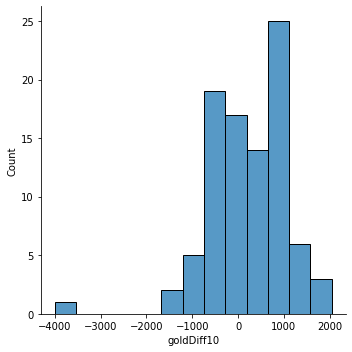

In [34]:
kev_adc=gold_diff_x(df_mk,"AerialBlast",minutes=[10,15],role="BOT_CARRY")
sns.displot(kev_adc.goldDiff10, bins =13)
print(len(kev_adc), " games, ")
print(int(kev_adc.goldDiff10.mean()), "avg gold diff")

92  games, 
333 avg gold diff


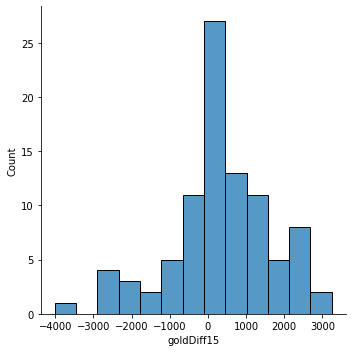

In [35]:
sns.displot(kev_adc.goldDiff15, bins = 13)
print(len(kev_adc), " games, ")
print(int(kev_adc.goldDiff15.mean()), "avg gold diff")

92  games, 
170 avg gold diff


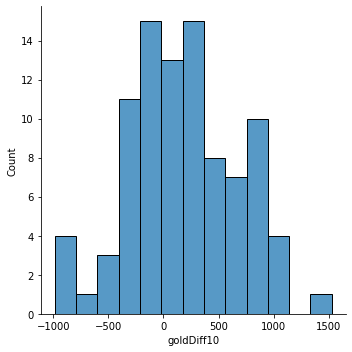

In [30]:
mike_support=gold_diff_x(df_mk,"SouporSecret",minutes=[10,15],role="SUPPORT")
sns.displot(mike_support.goldDiff10, bins = 13)
print(len(mike_support), " games, ")
print(int(mike_support.goldDiff10.mean()), "avg gold diff")

92  games, 
285 avg gold diff


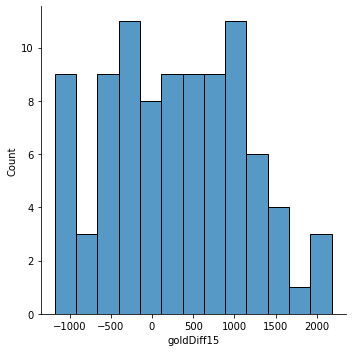

In [31]:
sns.displot(mike_support.goldDiff15, bins = 13)
print(len(mike_support), " games, ")
print(int(mike_support.goldDiff15.mean()), "avg gold diff")

In [11]:
x=['1','2','3']
y=['3','4','5']
z=set(x+y)
for i in z:
    print (i)

1
2
3
4
5


In [25]:
c=2
for i in range(10):
    print("i ", i)
    c=c+1
    for j in [1,2,3]:
        c=c+1
        print("j ", j)
        print("c ",c)
        if(c==8):
            print("here")
            break


i  0
j  1
c  4
j  2
c  5
j  3
c  6
i  1
j  1
c  8
here
i  2
j  1
c  10
j  2
c  11
j  3
c  12
i  3
j  1
c  14
j  2
c  15
j  3
c  16
i  4
j  1
c  18
j  2
c  19
j  3
c  20
i  5
j  1
c  22
j  2
c  23
j  3
c  24
i  6
j  1
c  26
j  2
c  27
j  3
c  28
i  7
j  1
c  30
j  2
c  31
j  3
c  32
i  8
j  1
c  34
j  2
c  35
j  3
c  36
i  9
j  1
c  38
j  2
c  39
j  3
c  40
